In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/liveness_detection

/content/drive/MyDrive/liveness_detection


In [ ]:
pwd

'/content/drive/MyDrive/liveness_detection'

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array

2024-11-30 16:55:31.040681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732960531.144804   70933 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732960531.177681   70933 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 16:55:31.765489: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.18.0
Num GPUs Available:  1


In [5]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.1


In [2]:
# Direktori dataset
DATASET_DIR = "../datasets/datasets/"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

In [3]:
TRAIN_SET = os.path.join(DATASET_DIR, "train_looking_right_set")
TEST_SET = os.path.join(DATASET_DIR, "test_looking_right_set")

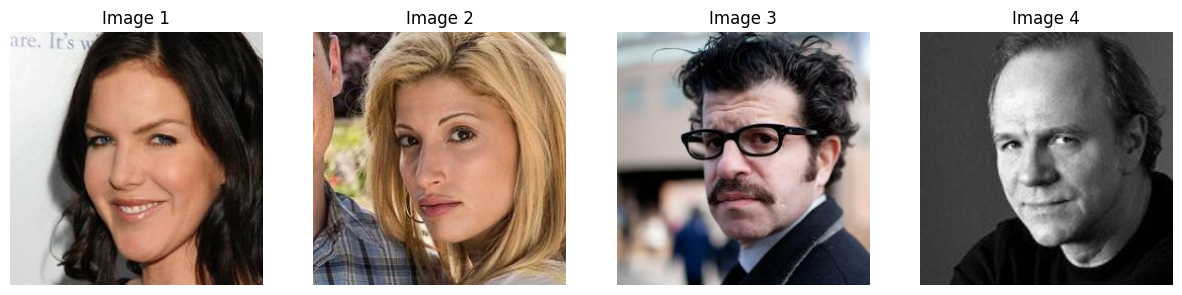

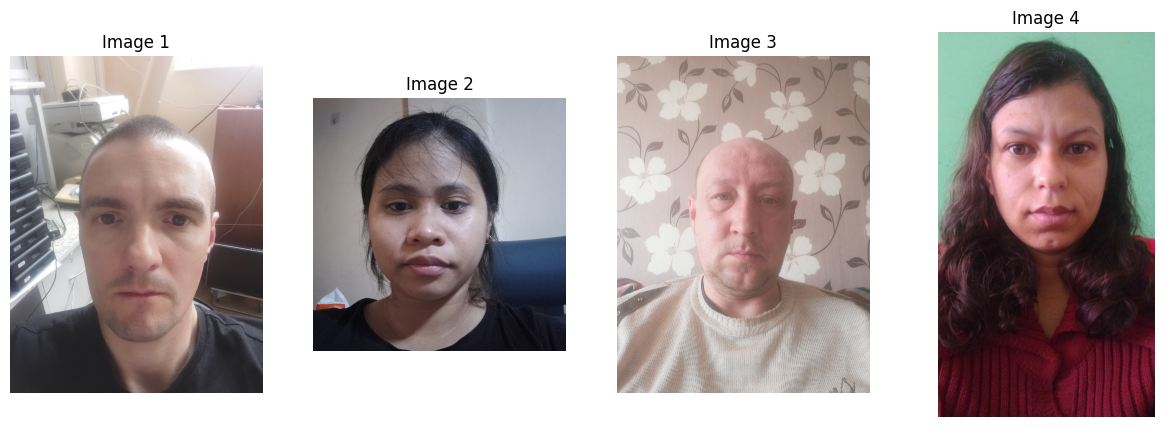

In [4]:
# Fungsi untuk menampilkan gambar
def show_images(directory, num_images=5):
  """Menampilkan beberapa gambar dari direktori yang diberikan.

  Args:
    directory: Path ke direktori yang berisi gambar.
    num_images: Jumlah gambar yang akan ditampilkan.
  """
  image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
  fig, axes = plt.subplots(1, min(num_images, len(image_files)), figsize=(15, 5))
  for i, ax in enumerate(axes):
      if i < len(image_files):
          image_path = os.path.join(directory, image_files[i])
          img = mpimg.imread(image_path)
          ax.imshow(img)
          ax.axis('off')
          ax.set_title(f"Image {i+1}")
  plt.show()

# Menampilkan 4 gambar dari direktori "real" dalam dataset
left = os.path.join(TRAIN_SET, "right")
show_images(left, num_images=4)

# Menampilkan 4 gambar dari direktori "fake" dalam dataset
front_facing = os.path.join(TRAIN_SET, "front_facing")
show_images(front_facing, num_images=4)


In [7]:
# Pilih satu gambar secara acak dari direktori attack dan liveness
right_dir = os.path.join(TRAIN_SET, 'right')
front_ = os.path.join(TRAIN_SET, 'front_facing')

right_images = [os.path.join(right_dir, f) for f in os.listdir(right_dir) if os.path.isfile(os.path.join(right_dir, f))]
liveness_images = [os.path.join(front_, f) for f in os.listdir(front_) if os.path.isfile(os.path.join(front_, f))]

random_attack_image_path = random.choice(right_images)
random_liveness_image_path = random.choice(liveness_images)

image_paths = [random_attack_image_path, random_liveness_image_path]

In [8]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Fungsi untuk melakukan cropping pada gambar
def crop_center(image, cropx, cropy):
    y, x, _ = image.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return image[starty:starty+cropy, startx:startx+cropx]

# Fungsi preprocessing yang menggabungkan cropping dan preprocessing MobileNetV3
def preprocess_and_crop(image):
    image = img_to_array(image)
    image = crop_center(image, 224, 224)
    image = preprocess_input(image)
    return image

In [9]:
# Data augmentation dan preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_and_crop,
    validation_split=0.2,
    brightness_range=[0.7, 1.3],
    # horizontal_flip=True,
    # vertical_flip=True,
    rotation_range=20,
    zoom_range=0.3,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    fill_mode='nearest',
    channel_shift_range=0.2
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_and_crop)

train_generator = train_datagen.flow_from_directory(
    TRAIN_SET,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    TEST_SET,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 1524 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


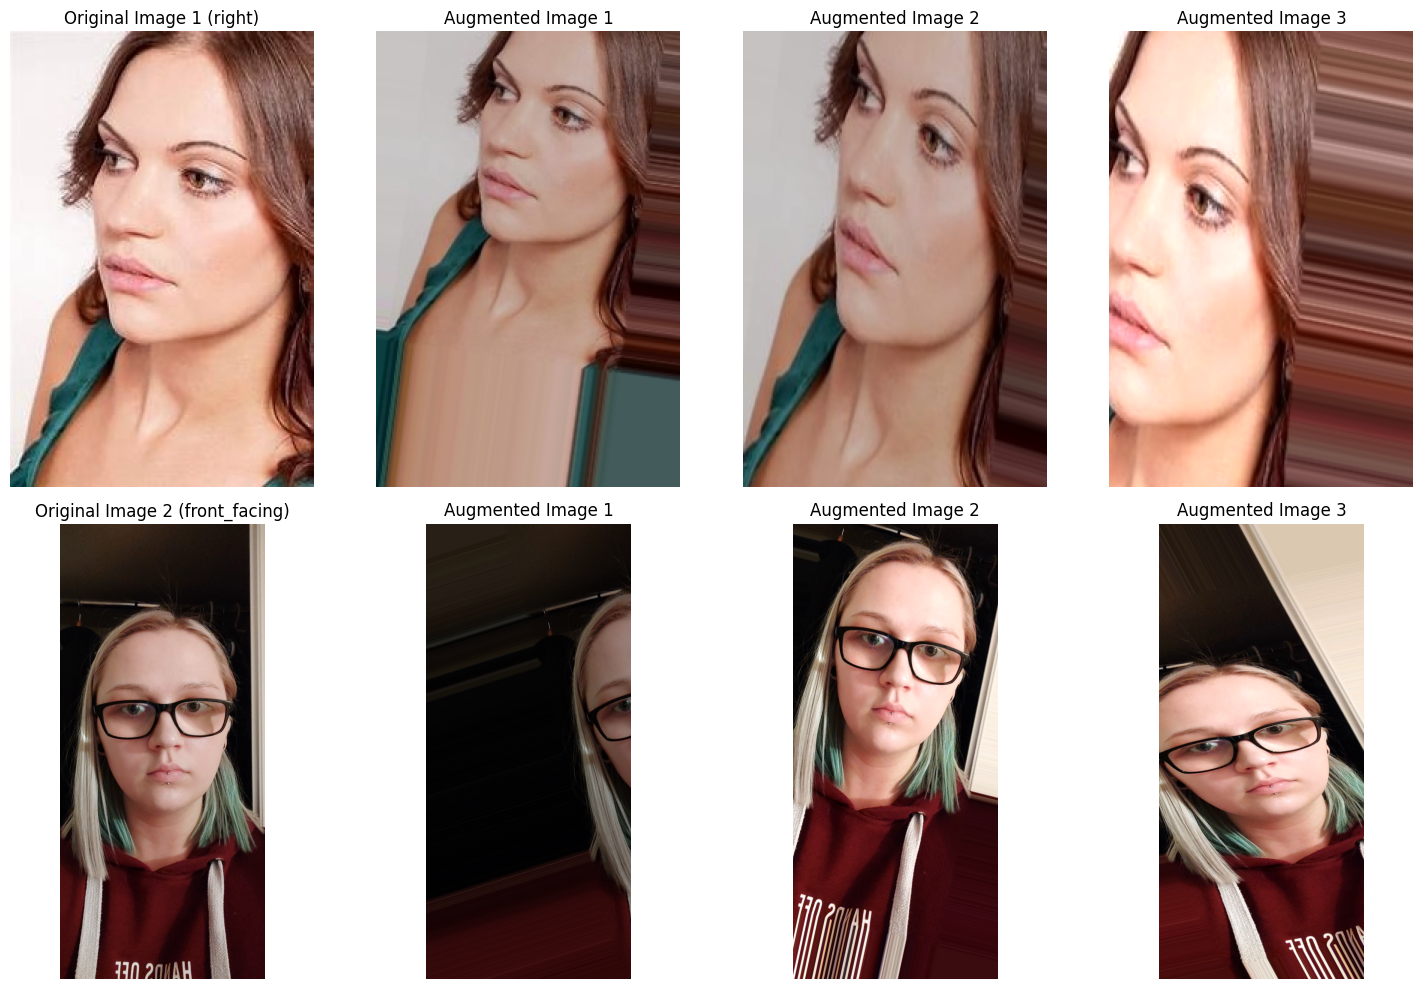

In [7]:
# Load dan augmentasi gambar
fig, axes = plt.subplots(2, 4, figsize=(15, 10))
for i, img_path in enumerate(image_paths):
  img = load_img(img_path)
  x = img_to_array(img)
  x = x.reshape((1,) + x.shape)

  # Buat ImageDataGenerator untuk augmentasi
  datagen = train_datagen

  # Generate gambar augmentasi
  augmented_images = [next(datagen.flow(x, batch_size=1))[0] for _ in range(3)]

  # Tampilkan gambar original dan augmentasi
  axes[i, 0].imshow(img)
  axes[i, 0].set_title(f"Original Image {i+1} ({'right' if i == 0 else 'front_facing'})")
  axes[i, 0].axis('off')

  for j, augmented_image in enumerate(augmented_images):
    axes[i, j+1].imshow(augmented_image.astype('uint8'))
    axes[i, j+1].set_title(f"Augmented Image {j+1}")
    axes[i, j+1].axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Model Transfer Learning dengan EfficientNetB_

# from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.01))(x)
x = MaxPooling2D(2, 2)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Fine-tuning
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

I0000 00:00:1732961071.089820   70933 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if acc is not None and val_acc is not None:
            if acc >= 0.99 and val_acc >= 0.98999:
                print("\nReached target accuracy, stopping training...")
                self.model.stop_training = True

In [11]:
# Callback
checkpoint_path = "../model_downlod/looking_right/model_looking_right_4.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_path,
                monitor="val_accuracy",
                verbose=1,
                save_best_only=True,
                save_weights_only=False,
                mode="max",
                save_freq="epoch",
            )
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# custom_callback = CustomCallback()

In [ ]:
# Training
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint,
               early_stopping,
              #  custom_callback,
               lr_scheduler]
)

/home/brimbi21/anaconda3/envs/lDetection/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


2024-11-30 17:06:02.492021: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
I0000 00:00:1732961162.521101   74647 service.cc:148] XLA service 0x7f6be4003a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732961162.521810   74647 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-11-30 17:06:02.755728: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732961164.041357   74647 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-30 17:06:05.973550: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3328_0', 8 bytes spill stores, 8 bytes spill loads

2024-11-30 17:07:59.020876: I extern

In [11]:
# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(val_data)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 361ms/step - Precision: 1.0000 - Recall: 0.9340 - accuracy: 0.9671 - loss: 0.3395
Loss: 0.34172526001930237, Accuracy: 0.9704142212867737, Precision: 1.0, Recall: 0.9408283829689026


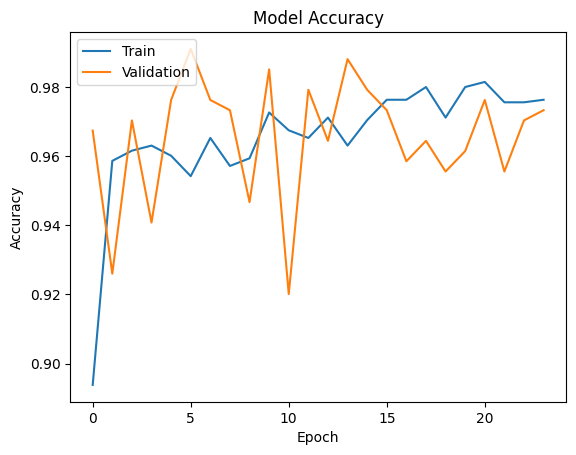

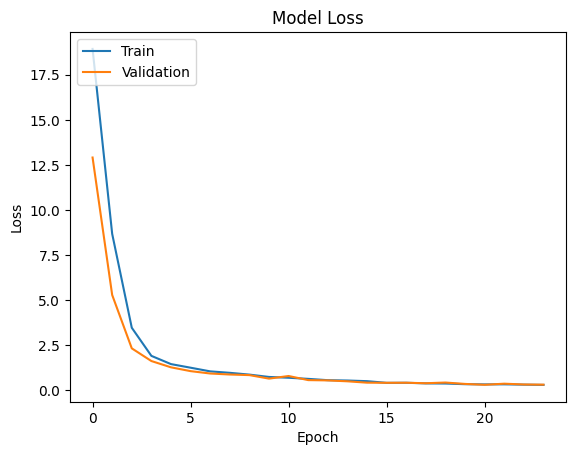

In [12]:
# Plot accuracy dan val_accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss dan val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'val_data' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
Prediction: Looking Right
Confidence score: 0.6672


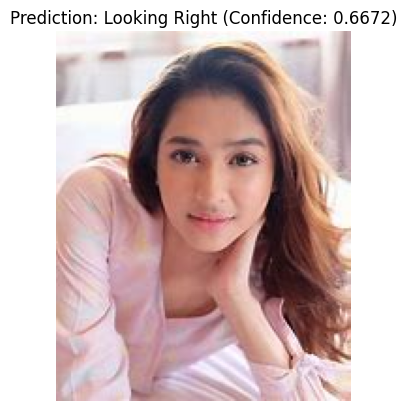

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction: Looking Right
Confidence score: 0.9318


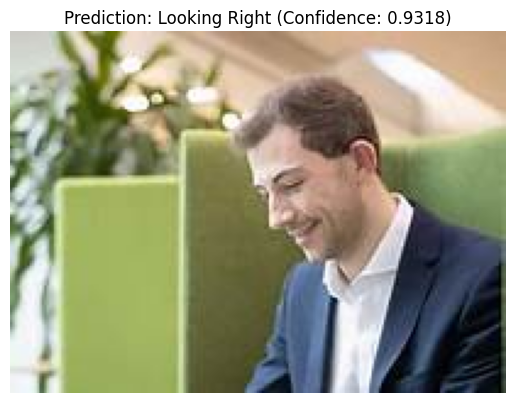

: 

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('../datasets/pictures/model_download/model_looking_right.keras')

# Function to preprocess an image for prediction
def preprocess_image(image_path):
  img = load_img(image_path, target_size=IMG_SIZE)
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  # img_array /= 255.  # Normalize the image if your model expects normalized input
  return img_array

# Function to predict and display results
def predict_image(image_path):
  preprocessed_image = preprocess_image(image_path)
  prediction = model.predict(preprocessed_image)

  if prediction[0][0] > 0.5:
    label = "Looking Right"
  else:
    label = "Front_Facing"

  confidence = prediction[0][0] if label == "Looking Right" else 1 - prediction[0][0]

  print(f"Prediction: {label}")
  print(f"Confidence score: {confidence:.4f}")
  img = mpimg.imread(image_path)
  plt.imshow(img)
  plt.title(f"Prediction: {label} (Confidence: {confidence:.4f})")
  plt.axis('off')
  plt.show()


# Example usage:
test_image_path1 = "../datasets/test/test/OIP (1).jpeg"
test_image_path2 = "../datasets/test/test/right.jpeg"


predict_image(test_image_path1)
predict_image(test_image_path2)


In [5]:
# COnvert to tflite

model = tf.keras.models.load_model('../datasets/pictures/model_download/model_looking_right.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model) 
tflite_model = converter.convert()

tflite_model_path = '../datasets/pictures/model_download/model_looking_right.tflite' 
with open(tflite_model_path, 'wb') as f: 
    f.write(tflite_model) 
    
print(f"Model converted and saved to {tflite_model_path}")

INFO:tensorflow:Assets written to: /tmp/tmpfz4k1dq_/assets


INFO:tensorflow:Assets written to: /tmp/tmpfz4k1dq_/assets


Saved artifact at '/tmp/tmpfz4k1dq_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139853233850320: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  139853233848736: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  139849286027392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139849286025456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139849286032672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139849286030384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139849286031440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139849286037072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139849286036720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139849286039536: TensorSpec(shape=(), dtype=tf.resource, name=None)

W0000 00:00:1731992001.734051   13239 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1731992001.734122   13239 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-19 11:53:21.734519: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpfz4k1dq_
2024-11-19 11:53:21.768585: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-19 11:53:21.768627: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpfz4k1dq_
I0000 00:00:1731992002.077219   13239 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2024-11-19 11:53:22.134356: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-19 11:53:24.284329: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpfz4k1dq_
2024-11-19 11:53:24.888255: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

Model converted and saved to ../datasets/pictures/model_download/model_looking_right.tflite
